In [44]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
import datetime
import threading
import logging
import time
import itertools
import smtplib
from email.mime.text import MIMEText
from collections import Counter
import csv
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os

In [45]:
# constants
ONLINE = True
root_location = r'C:\Users\user\Documents'
metal_playlist_id = '4ssXZYi62I26fM0sPoHxjA'
non_metal_playlist_id = '5eVujgZHVyWxP9AETB2ZEP'
prediction_playlist_id = "5kwIeMf9pQVCMwpSo2on55"
features_to_use = ["duration_ms","acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","valence"]

In [46]:
# Spotify utils

client_id = "YOUR_CLIENT_ID_HERE"
client_secret = "YOUR_CLIENT_SECRET_HERE"
redirect_uri = "http://localhost:9999/callback"
scope = "playlist-modify-private"

def get_all_playlist_track_details(sp,playlist_id):
    def add_features(playlist_tracks):
        tracks = [pt['track'] for pt in playlist_tracks]
        track_features = sp.audio_features([t["id"] for t in tracks])
        return list(zip(tracks,track_features))
    results = sp.playlist_tracks(playlist_id)
    collected_tracks = add_features(results['items'])
    while results['next']:
        results = sp.next(results)
        collected_tracks.extend(add_features(results['items']))
    track_details_list = []
    for track,features in collected_tracks:
        details = dict()
        details["id"]=track["id"]
        details["name"]=track["name"]
        details["album_id"]=track["album"]["id"]
        details["album_name"]=track["album"]["name"]
        details["artist_id"]=track["artists"][0]["id"]
        details["artist_name"]=track["artists"][0]["name"]
        if not features: continue
        for f in features_to_use:
            details[f] = features[f]
        details["duration_ms"]=track["duration_ms"]
        track_details_list.append(details)
    return track_details_list

def export_to_csv(name,data):
    with open(os.path.join(root_location,'%s_data.csv' % name),'w',newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, data[0].keys())
        dict_writer.writeheader()
        dict_writer.writerows(data)
              
def import_from_csv(name):
    with open(os.path.join(root_location,'%s_data.csv' % name),'r',newline='') as data_file:
        return list(csv.DictReader(data_file))

def dict_list_to_dataframe(dicts):
    return pd.DataFrame(dicts,columns=dicts[0].keys())

In [47]:
# Retrieve data
if ONLINE:
    # Get data from spotify
    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri))
    metal_tracks = get_all_playlist_track_details(sp,metal_playlist_id)
    non_metal_tracks = get_all_playlist_track_details(sp,non_metal_playlist_id)
    #export_to_csv('metal',metal_tracks)
    #export_to_csv('non_metal',non_metal_tracks)
else:
    metal_tracks = import_from_csv('metal')
    non_metal_tracks = import_from_csv('non_metal')
metal_tracks_df = dict_list_to_dataframe(metal_tracks)
non_metal_tracks_df = dict_list_to_dataframe(non_metal_tracks)

In [48]:
# Unify the two data sets
metal_tracks_df["is_metal"] = 1
non_metal_tracks_df["is_metal"] = 0
model_tracks_df = pd.concat([metal_tracks_df,non_metal_tracks_df])

In [49]:
# Split to data and target
X = model_tracks_df
y = model_tracks_df["is_metal"]

In [50]:
# Plot a 2d scatter matrix
# pd.plotting.scatter_matrix(X,c=y,figsize=(20,20),marker='o',hist_kwds={'bins':20},s=200,alpha=.8)
# plt.show()

In [51]:
# Find uncorrelated features

In [54]:
# Evaluating different models

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from math import sqrt

param_grid = [
    # {'classifier': [KNeighborsClassifier()], 'preprocessing': [StandardScaler(), None],
    #  'classifier__n_neighbors': [1,3,5]
    # },
    # {'classifier': [LinearRegression()], 'preprocessing': [StandardScaler(), None]
    # },
    # {'classifier': [DecisionTreeClassifier()], 'preprocessing': [StandardScaler(), None],
    #  'classifier__max_depth': [1,2,3,4]
    # },
    {'classifier': [RandomForestClassifier()],
     'preprocessing': [StandardScaler(),None],
     'classifier__max_features': [1, int(sqrt(len(features_to_use))), len(features_to_use)],
     'classifier__n_estimators': [1, 10, 100],
     'classifier__min_samples_split': [2, 5, 10]
    },
    {'classifier': [RandomForestClassifier()],
     'preprocessing': [None],
     'classifier__max_features': [len(features_to_use)],
     'classifier__n_estimators': [100],
     'classifier__min_samples_split': [10]
    }
    ]
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier())], memory="cache_folder")
grid_search = GridSearchCV(pipe,param_grid,cv=5)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)
grid_search.fit(X_train[features_to_use].astype(float),y_train)

print("Best params:\n{}\n".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test-set score: {:.2f}".format(grid_search.score(X_test[features_to_use].astype(float), y_test)))

chosen_model = grid_search

Best params:
{'classifier': RandomForestClassifier(max_features=3, min_samples_split=5), 'classifier__max_features': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.93
Test-set score: 0.92


In [55]:
X_test_copy = X_test
X_test_copy["prediction"] = chosen_model.predict(X_test[features_to_use].astype(float))
X_test_copy["truth"] = y_test
test_errors = X_test_copy[~(X_test_copy["prediction"]==X_test_copy["truth"])]
display(test_errors[["artist_name","name","prediction","truth"]])

,artist_name,name,prediction,truth
858,Slipknot,Danger - Keep Away,0,1
214,Lady Gaga,Marry The Night,1,0
438,Black Sabbath,Evil Woman,0,1
50,KISS,Rock And Roll All Nite,0,1
542,Animal Collective,My Girls,1,0
648,Luude,Down Under (feat. Colin Hay),1,0
756,Surf Curse,Freaks,1,0
270,Ryuven,"The Rumbling (From ""Attack on Titan"")",0,1
56,Peach Pit,Tommy's Party,1,0
18,Beach House,Myth,1,0


In [28]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri))
prediction_tracks = get_all_playlist_track_details(sp,prediction_playlist_id)
prediction_tracks_df = dict_list_to_dataframe(prediction_tracks)
prediction_tracks_df["prediction: is metal?"] = chosen_model.predict(prediction_tracks_df[features_to_use])
prediction_tracks_df["probability"] = chosen_model.predict_proba(prediction_tracks_df[features_to_use])[:,1]
display(prediction_tracks_df[["artist_name","name","prediction: is metal?","probability"]])

,artist_name,name,prediction: is metal?,probability
0,The Beatles,Hey Jude - Remastered 2015,1,0.536732
1,Megadeth,Tornado Of Souls - Remastered 2004,1,0.929639
2,Miles Davis,"So What (feat. John Coltrane, Cannonball Adder...",0,0.303745
3,Led Zeppelin,Dazed and Confused - 1990 Remaster,0,0.457733
4,Slayer,Raining Blood,1,1.000000
5,Pink Floyd,The Great Gig in the Sky,0,0.340235
6,Faith No More,We Care a Lot,0,0.000000
7,Ozzy Osbourne,Mr. Crowley,1,0.569134
8,Run The Jewels,JU$T (feat. Pharrell Williams & Zack de la Rocha),0,0.000000


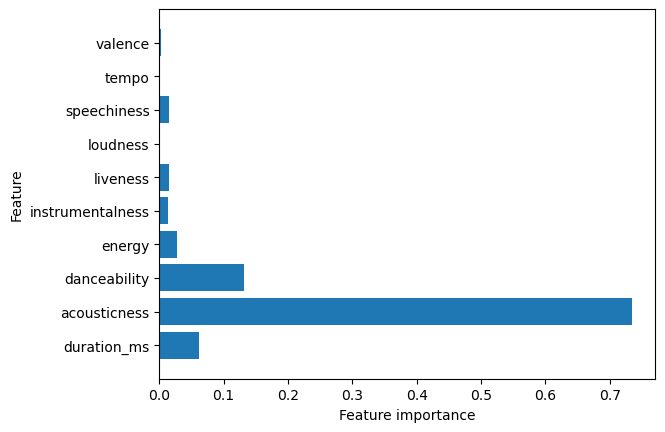

In [11]:
def plot_feature_importances(data,model):
    n_features = data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features_to_use)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(X,dtree)

In [13]:
# Visualize the decision tree
from sklearn.tree import export_graphviz
graph_file = os.path.join(root_location,"tree.dot")
export_graphviz(dtree, out_file=graph_file, class_names=["Metallica", "Madonna"],
                feature_names=features_to_use, impurity=False, filled=True)
import graphviz
with open(graph_file) as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\user\\Documents\\tree.dot'